# Analyzing `TGF`, `HUC12`, `MERIT-Basins`, and `PFRA` geofabric for the St. Mary & Milk River Basins

Here, the mentioned geofabrics for the upcoming St. Mary & Milk River Basins (hereinafter SMM) study are analyzed and their applicability is tested.

## Importing necessary libraries

In [1]:
import geopandas as gpd # version 0.12.2
import matplotlib.pyplot as plt # version 3.7.0
import fiona # version 1.9.2
import pandas as pd # version 1.5.3
import contextily as cx # version 1.3.0

from itertools import permutations # Python 3.11 (built-in function)
from matplotlib.patches import Patch # version 3.7.0

# Also:
# * jupyterlab-markup v2.0.0 (for printing data in Markdown)
# * Python >3.11

___

## Reading files

### `TGF`, Transboundary Geospatial Fabric (Retreived from [DOI 10.5066/P971JAGF](https://doi.org/10.5066/P971JAGF))

In [2]:
# defining the path
tgf_path = '/Users/kasrakeshavarz/Documents/geospatial-data/StMary-Milk/TGF/TGF.gdb'

In [3]:
# Getting a list of all layers available in TGF
fiona.listlayers(tgf_path)

['POIs', 'waterbodies', 'nhru', 'nsegment']

In [4]:
# reading different layers of interest
tgf_basin = gpd.read_file(filename=tgf_path, driver='FileGDB', layer='nhru') # sub-basin layer
tgf_river = gpd.read_file(filename=tgf_path, driver='FileGDB', layer='nsegment') # river network layer

### `HUC12` Geofabric for the SMM Area (Retrieved from ECCC, [Jamie Kolodinsky](mailto:Jamie.Kolodinsky@ec.gc.ca))

In [5]:
# define the path
huc12_path = '/Users/kasrakeshavarz/Documents/geospatial-data/StMary-Milk/HUC/HUC12/SMM_HUC12.shp'

In [6]:
# Reading the layer
huc12_basin = gpd.read_file(filename=huc12_path) # sub-basin layer

**Note**: For the HUC12 layer, only the sub-basin layer is provided.

### `MERIT-Basins` Geofabric Subset for the SMM Area (Retrieved from [DOI 10.1029/2019WR025287](https://doi.org/10.1029/2019WR025287)

In [7]:
# define the path
mrb_basin_path = '/Users/kasrakeshavarz/Documents/geospatial-data/StMary-Milk/MERIT-Basins/SMM_updown_select/smm_catchments.shp' # sub-basin layer
mrb_river_path = '/Users/kasrakeshavarz/Documents/geospatial-data/StMary-Milk/MERIT-Basins/SMM_updown_select/smm_rivers.shp' # river layer

In [8]:
# read the layers
mrb_basin = gpd.read_file(filename=mrb_basin_path) # sub-basin layer
mrb_river = gpd.read_file(filename=mrb_river_path) # river network layer

### `PFRA` Geofabric for the Canadian Prairies (Retrieved from [Canada Open Data](https://open.canada.ca/data/en/dataset/c20d97e7-60d8-4df8-8611-4d499a796493))

Based on `PFRA` layer's [manual](https://agriculture.canada.ca/atlas/data_donnees/watersheds2013/supportdocument_documentdesupport/en/ISO_19131_AAFC_Watersheds_Project_2013_Data_Product_Specification.pdf), the **'Incremental Gross Drainage Areas'** and **'Non-contributing Areas with Incremental Gross Drainage Areas'** are defined as following:

* The **“Incremental Gross Drainage Areas of the AAFC Watersheds Project - 2013”** dataset is a geospatial data layer containing polygon features representing the incremental gross drainage areas of the Agriculture and Agri-Food Canada (AAFC) Watersheds Project. The Project area is subdivided by hydrometric gauging station. The maximum area that could contribute runoff to each station, less that of its upstream neighbour(s) is called an ‘incremental gross drainage area’. [pp. 13]

* The **“Non-contributing Portions of the Incremental Gross Drainage Areas of the AAFC Watersheds Project – 2013”** dataset is a geospatial data layer containing polygon features representing the areas within each incremental gross drainage area of the Agriculture and Agri-Food Canada (AAFC) Watersheds Project that DO NOT contribute to average runoff. The Project is subdivided by hydrometric gauging station. The maximum area that could contribute runoff to each gauging station, less that of its upstream neighbour(s) is called an “incremental gross drainage area”. The “incremental gross drainage” areas can be subdivided into portions that either supply surface runoff to an average runoff, or do not. Those portions that are NOT part of the effective drainage area are called ‘non-contributing’. [pp. 13]

In [9]:
# define the paths
pfra_gross_path = '/Users/kasrakeshavarz/Documents/geospatial-data/PFRA/fgdb/fgdb/HYD_AAFC_INCRML_GROSS_DRAIN.gdb/' # 'Incremental Gross Drainage Area' sub-basin layer
pfra_nca_path   = '/Users/kasrakeshavarz/Documents/geospatial-data/PFRA/fgdb/fgdb/HYD_AAFC_INCRML_NON_CTRB_DRAIN.gdb/' # 'Non-contributing Areas' within 'Incremental Gross Drainage Areas' layer

In [10]:
# print the layers within each File GeoDataBase
print('Gross layer includes: ', fiona.listlayers(pfra_gross_path))
print('Non-contributing layer includes: ', fiona.listlayers(pfra_nca_path))

Gross layer includes:  ['HYD_AAFC_INCRML_GROSS_DRAIN']
Non-contributing layer includes:  ['HYD_AAFC_INCRML_NON_CTRB_DRAIN']


In [11]:
# read layers
pfra_gross = gpd.read_file(pfra_gross_path, driver='FileGDB', layer='HYD_AAFC_INCRML_GROSS_DRAIN') # 'Gross' sub-basin layer
pfra_nca   = gpd.read_file(pfra_nca_path, driver='FileGDB', layer='HYD_AAFC_INCRML_NON_CTRB_DRAIN') # 'Non-contributing Area' sub-basin layer

____

## Necessary Pre-processings and Definitions

### Boundary Layer
The `HUC12` layer is chosen to extract the boundary layer of the `SMM` system:

<Axes: >

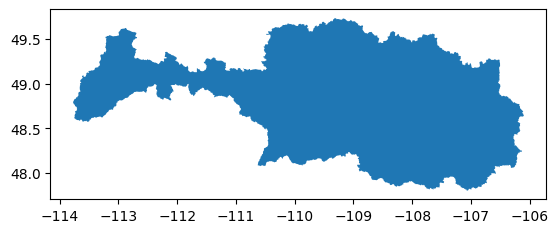

In [12]:
smm_boundary = huc12_basin.dissolve()
smm_boundary.plot()

### Modifying MERIT-Basins to include its non-contributing areas

The `MERIT-Basins` layer extracted for the `SMM` area, is based on the `get_all_upstream` of the [EASYMORE](https://github.com/ShervanGharari/EASYMORE/tree/main) package [version 0.0.4](https://github.com/ShervanGharari/EASYMORE/blob/98aa151bdb956e900978b98fea96242a2617c95a/easymore/easymore.py#L2190-L2219). However, this function does not consider the non-contributing areas, as technically, these areas are not connected to the network extracted given the up-/downstream connectivity. 

In [13]:
# read pfaf74 from MERIT-Basins and add the non-contributing areas manually
## paths
mrb_74_cat_path = '/Users/kasrakeshavarz/Documents/geospatial-data/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/pfaf_level_02/cat_pfaf_74_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'
mrb_74_riv_path = '/Users/kasrakeshavarz/Documents/geospatial-data/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/pfaf_level_02/riv_pfaf_74_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'

## read into GeoPandas DataFrames
mrb_74_cat = gpd.read_file(mrb_74_cat_path)
mrb_74_riv = gpd.read_file(mrb_74_riv_path)

## non-contributing (nca, or missing) COMIDs - extracted manually by looking at the map on QGIS [FIXME later for automation]
nca_comids = [74000629, 74000612]

In [14]:
# concatenation
mrb_basin = pd.concat([mrb_basin, mrb_74_cat.loc[mrb_74_cat.COMID.isin(nca_comids), :]]) # adding missing nca comids to mrb_basin
mrb_river = pd.concat([mrb_river, mrb_74_riv.loc[mrb_74_riv.COMID.isin(nca_comids), :]]) # adding missing nca comids to mrb_river

/Users/kasrakeshavarz/Documents/virtualenvs/jupyter/lib/python3.11/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


In [15]:
# resetting index
mrb_basin.reset_index(drop=True, inplace=True)
mrb_river.reset_index(drop=True, inplace=True)

### Intersection/Overlap Extraction for `TGF` and `PFRA`

In [16]:
# tgf overlapping with SMM boundary
tgf_overlapping_smm = gpd.sjoin(left_df=tgf_basin.to_crs(epsg=4326), 
                                right_df=smm_boundary.to_crs(epsg=4326), 
                                how='inner',
                                lsuffix='TGF',
                                rsuffix='HUC12')

In [17]:
# extract `clipped` polygons
pfra_nca_clip_smm = pfra_nca.to_crs(epsg=4326).clip(smm_boundary.to_crs(epsg=4326))
pfra_nca_clip_smm = pfra_nca_clip_smm[~pfra_nca_clip_smm.is_empty]

## Analysis

### Non-contributing Areas of each Geofabric Dataset

The `smm_boundary` is used as defined in 1.3. as the boundary layer:

For `HUC12`, the `tohuc` column contains values as `CLOSED BASIN` where it indicates the basin does not contribute to the overall flow of the system. Furthermore, the `areasqkm` columns shows the area of each sub-basin in $km^{2}$.

In [18]:
# HUC12's non-contributing areas in km2
huc12_nca_smm = huc12_basin.loc[huc12_basin.tohuc == 'CLOSED BASIN', :]

For `MERIT-Basins`, the non-contributing areas are those that have a non-valid value assigned to their corresponding `NextDownID` in the `mrb_river` GeoDataFrame. Furthermore, the `unitarea` column of the `mrb_basin` GeoDataFrame (or `uparea` of `mrb_river`) shows the area of each non-contributing sub-basin in $km^{2}$.

In [19]:
# MERIT-Basins's non-contributing areas in km2
mrb_nca_smm = mrb_basin.loc[mrb_river.NextDownID == 0, :]

For `TGF`, first, the layer is checked to see which polygons overlaps with the `SMM` area. Second, the overlaped areas are taken into account to calculate the non-contributing areas. The non-contributing areas are those sub-basin features with `Type_NCA` column values of `1` based on the [metadata](https://www.sciencebase.gov/catalog/file/get/5d967365e4b0c4f70d113923?f=__disk__8e%2Fc1%2Ff2%2F8ec1f28a8cf2ae860dc01dc61d0ce676f653ff75&transform=1&allowOpen=true) of the dataset. Moreover, the area of each sub-basin is printed under `Shape_Area` column of the `tgf_basin` GeoDataFrame in the unit of $m^{2}$.

In [20]:
# TGF's non-contributing areas in km2
tgf_nca_smm = tgf_overlapping_smm.loc[tgf_overlapping_smm.Type_NCA==1, :]

For `PFRA`'s non-contributing areas, first the 'Non-contributing Areas within Incremental Gross Drainage Areas' layer is checked to see which polygons intersect with the `SMM` area. Second, the area of the **clipped** polygons are calculated after transforming their Coordinate Reference System (CRS) to EPSG value of `6931` based on [Brodzik et al. (2023)](https://doi.org/10.3390/ijgi1010032). The CRS transformation is done to get the best estimate of the areas (see the reference for more details.)

In [21]:
# calculate areasqkm column
## transform to EPSG=6931 and calculate area. Then convert the unit to sqkm
pfra_nca_clip_smm['areasqkm'] = pfra_nca_clip_smm.to_crs(epsg=6931).area/1e6
## reorder columns
cols = pfra_nca_clip_smm.columns.tolist() # make a list of columns
cols = cols[:-2] + list(reversed(cols[-2:])) # reorder columns
pfra_nca_clip_smm = pfra_nca_clip_smm[cols] # assign new columns
pfra_nca_clip_smm.columns = pfra_nca_clip_smm.columns.tolist()[:-2] + ['areasqkm'] + [pfra_nca_clip_smm.columns.tolist()[-1]] # rename area column

### Summary of Non-Contributing Areas of each Geofabric Dataset

In [22]:
# Summary of the 4 geofabric layers
huc12_nca_area = huc12_nca_smm.loc[:, 'areasqkm'].sum() # in sqkm
tgf_nca_area = tgf_nca_smm.loc[:, 'Shape_Area'].sum()/1e6 # in sqkm
mrb_nca_area = mrb_nca_smm.loc[:, 'unitarea'].sum() # in sqkm
pfra_nca_area = pfra_nca_clip_smm.loc[:, 'areasqkm'].sum() # in sqkm

Non-Contributing Areas of each Geofabric dataset in $km^{2}$:
|#    |Geofabric      |Non-Contributing Areas ($km^{2}$)|
|:---:|:--------------|:-------------------------------:|
|1    |`HUC12`        |{{ '%.2f' % huc12_nca_area }}    |
|2    |`TGF`          |{{ '%.2f' % tgf_nca_area }}      |
|3    |`MERIT-Basins` |{{ '%.2f' % mrb_nca_area }} ± 20 |
|4    |`PFRA`         |{{ '%.2f' % pfra_nca_area }}     |

**NOTE**: Since there is hole in the MERIT-Basins sub-basin polygons that was not delineated, an area of ±20 $km^{2}$ is added to the `MERIT-Basins` Non-contributing Areas.

### Shared Non-Contributing Areas between Pairs of Geofabric Datasets

In [23]:
# `common_area` intersects two layers and calculates total area (km2) in EPSG=6931 projection
common_area = lambda gdf1, gdf2 : gpd.overlay(gdf1.to_crs(epsg=4326), gdf2.to_crs(epsg=4326), how='intersection').to_crs(epsg=6931).area.sum()/1e6

# dictionary of geofabrics for SMM
geo_dict = {'HUC12':huc12_nca_smm, 
            'TGF':tgf_nca_smm,
            'MERIT-Basins':mrb_nca_smm,
            'PFRA':pfra_nca_clip_smm,
           }

# Pre-allocating a Pandas DataFrame to store the common NCAs between pairs of datasets
common_nca = pd.DataFrame([], index=geo_dict.keys(), columns=geo_dict.keys())

# Calculating common NCAs between datasets
for perm in permutations(geo_dict, 2):
    common_nca.loc[perm] = common_area(geo_dict[perm[0]], geo_dict[perm[1]])

The Non-Contributing Areas shared between pairs of Geofabric Datasets (in $km^{2}$):

|Datasets               |{{common_nca.columns[0]}}         |{{common_nca.columns[1]}}         |{{common_nca.columns[2]}}         |{{common_nca.columns[3]}}         |
|:---------------------:|:--------------------------------:|:--------------------------------:|:--------------------------------:|:--------------------------------:|
|{{common_nca.index[0]}}|{{'%.2f'%common_nca.iloc[0,0]}}   |{{'%.2f'%common_nca.iloc[0,1]}}   |{{'%.2f'%common_nca.iloc[0,2]}}   |{{'%.2f'%common_nca.iloc[0,3]}}   |
|{{common_nca.index[1]}}|{{'%.2f'%common_nca.iloc[1,0]}}   |{{'%.2f'%common_nca.iloc[1,1]}}   |{{'%.2f'%common_nca.iloc[1,2]}}   |{{'%.2f'%common_nca.iloc[1,3]}}   |
|{{common_nca.index[2]}}|{{'%.2f'%common_nca.iloc[2,0]}}   |{{'%.2f'%common_nca.iloc[2,1]}}   |{{'%.2f'%common_nca.iloc[2,2]}}   |{{'%.2f'%common_nca.iloc[2,3]}}   |
|{{common_nca.index[3]}}|{{'%.2f'%common_nca.iloc[3,0]}}   |{{'%.2f'%common_nca.iloc[3,1]}}   |{{'%.2f'%common_nca.iloc[3,2]}}   |{{'%.2f'%common_nca.iloc[3,3]}}   |

### Visual Overview of Non-Contributing Areas of each Geofabric Dataset

In [24]:
def plot_nca(ax: plt.Axes,
             boundary: gpd.GeoDataFrame,
             nca_polys: gpd.GeoDataFrame,
             fig_size: tuple,
             title: str = None,
             nca_color: str = 'red',
             boundary_color: str = 'black',
             kwargs: dict = {},
):
    # plot boundary layer
    boundary.to_crs(epsg=3857).plot(figsize=fig_size, alpha=0.5, facecolor=boundary_color, edgecolor='black', ax=ax, **kwargs)
    # plot NCA polygons
    nca_polys.to_crs(epsg=3857).plot(alpha=0.5, facecolor=nca_color, edgecolor='black', ax=ax)
    # plot a basemap
    cx.add_basemap(ax, source=cx.providers.Stamen.Terrain, attribution_size=5)
    # setting the title
    if title:
        ax.set_title(title)
    # remove margins
    ax.margins(0)
    # adjust basemap
    basemap_pos = ax.get_position()
    ax.set_position([basemap_pos.x0, basemap_pos.y0, basemap_pos.width, 0.425])

        
    return ax

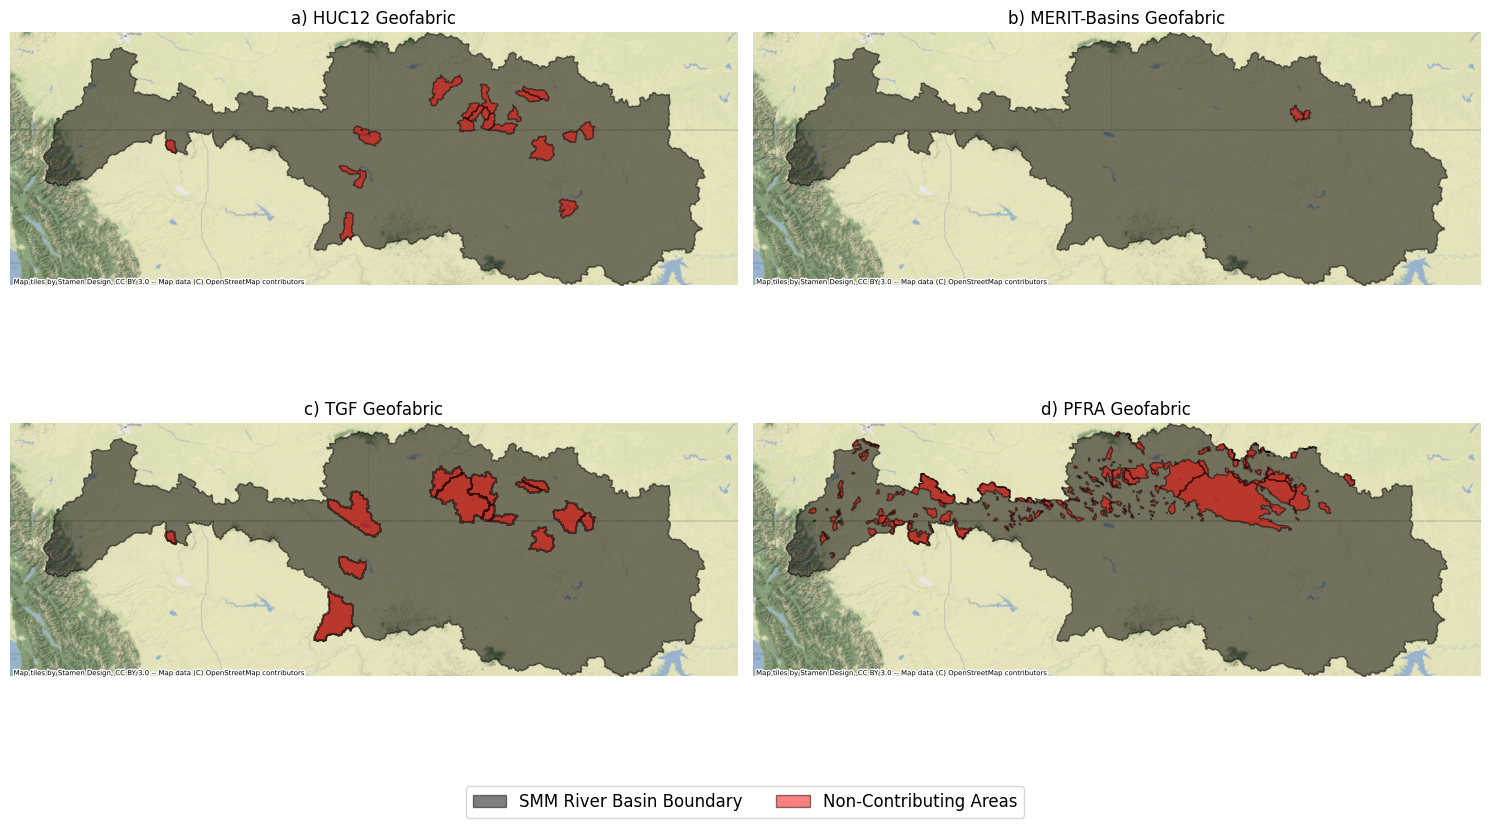

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))

for a in axes.flatten():
    a.axis('off')
    a.margins(y=0)
    
# HUC12 dataset
plot_nca(ax=axes[0,0],
         boundary=smm_boundary,
         nca_polys=huc12_nca_smm,
         fig_size=(15,10),
         title='a) HUC12 Geofabric')


# MERIT-Basins dataset
plot_nca(ax=axes[0,1],
         boundary=smm_boundary,
         nca_polys=mrb_nca_smm,
         fig_size=(15,10),
         title='b) MERIT-Basins Geofabric')

# TGF dataset
plot_nca(ax=axes[1,0],
         boundary=smm_boundary,
         nca_polys=tgf_nca_smm,
         fig_size=(15,10),
         title='c) TGF Geofabric')

# PFRA dataset
plot_nca(ax=axes[1,1],
         boundary=smm_boundary,
         nca_polys=pfra_nca_clip_smm,
         fig_size=(15,10),
         title='d) PFRA Geofabric')

# set legend items (common for all geofabric datasets)
legend_elements = [Patch(facecolor='black', edgecolor='black', alpha=0.5, label='SMM River Basin Boundary'),
                   Patch(facecolor='red', edgecolor='black', alpha=0.5, label='Non-Contributing Areas'),]

# set legend for the figure
fig.legend(handles=legend_elements, loc='lower center', fontsize=12, frameon=True, ncols=2)
fig.tight_layout()
# plt.savefig("/Users/kasrakeshavarz/Desktop/test.png", bbox_inches='tight')